In [ ]:
pip install dimod

In [1]:
import matplotlib.pyplot as plt
import pyqubo as pq
import numpy as np
import qubovert as qv
from neal import SimulatedAnnealingSampler

In [2]:
def ConvertSolution(q, a, b):
    '''
    Vectorised function to convert an array of an array of qubits into an array of real numbers
    '''
    q = np.array(q)
    
    if len(np.shape(q))==1: # Backwards compatibility
        q = np.array([q])
        #return ConvertSolution_old(q,a,b)
    
    # Convert to binary
    shape = q.shape # shape
    powers = 2.**np.arange(0,-shape[-1],-1) # powers of 2 in descending
    chi = np.sum(q*powers,axis=1) # multiply in
    #print('.',chi)
    
    # Scale and shift
    gamma = (b - a)/2
    #print(gamma)
    x = gamma * chi + a
    
    return x

def H(M, y, R = 2, a = -1, b = 3):
    '''
    M and y come from problem Mx-y
    R is bit-precision, ie number of qubits
    a, b endpoints of desired range, a < b, [a,b)
    
    https://arxiv.org/pdf/1901.06526.pdf Section 3, eq 3.17-18
    ''' 
    
    # Save the dimension of problem as N
    N = np.shape(y)[0]

    # Define the midpoint of the range, hard coded atm
    gamma = (b - a)/2
    pho = gamma ** 2 # 🍜
    print('Precision:',(b-a)/2**R, f'Range: [{a},{b})')
    
    #Intialise Q as vector of zeros 
    Q = np.zeros((N * R, N * R))
    
    # Compute strengths
    MTM = M.T@M
    
    strengths = np.zeros_like(Q)
    for r in range(R):
        for s in range(R): # nb. includes r=s, which is used for weights
            block = pho * 2**(-r-s) * MTM
            ind_s = np.arange(N)*R + s
            ind_r = np.arange(N)*R + r
            strengths[np.ix_(ind_s, ind_r)] += np.copy(block)
    Q += np.copy(strengths)
        
    # Compute weights
    weights = np.zeros_like(Q)
    
    My = np.diag(M.T@y)
    sumMTM = np.diag(np.sum(MTM, axis=1))
    for r in range(R):
        ind_r = np.arange(N)*R + r
        block1 = 2*gamma *2**(-r) * -1 * My
        block2 = -a*2*gamma *2**(-r) * -1 * sumMTM
        weights[np.ix_(ind_r, ind_r)] += np.copy(block1) + np.copy(block2)
    Q += np.copy(weights)
    return Q

def anneal(A,B,accuracy,a,b, num_anneals=None):
    '''Outputs solution to Ax=B''' 
    # Err catch
    assert a<b, 'a needs to be less than b'

    # Calculation
    
    # Save the dimension of problem as N
    N = np.shape(B)[0]

    Q = H(A,B, R = accuracy, a = a, b = b) # Get Q
    Q_qubo = qv.utils.matrix_to_qubo(Q) # Convert to qubo
    
    if num_anneals == None:
        num_anneals = 100*N**accuracy
    
    state = qv.sim.anneal_qubo(Q_qubo, num_anneals = num_anneals) # Pass to anneal
    res = np.array(list(state.best.state.values())) # Result
    
    x = res.reshape((len(res)//accuracy,accuracy)) # Split result for each component
    sol = ConvertSolution(x,a,b) # Convert each component to decimal
    
    return sol

def test_anneal(dim, accuracy, a, b, seed, num_anneals=None):
    np.random.seed(seed)

    A = np.arange(dim**2).reshape((dim,dim))
    C = np.random.randint(b,size=dim)
    B = A@C
    sol = anneal(A,B,accuracy,a,b, num_anneals)
    
    print('Actual', C)
    print('Computed', sol)
    print('Error = ', np.linalg.norm(C-sol))
    return sol

In [3]:
def q_anneal(A,B,accuracy,a,b, num_reads=None):
    '''Outputs solution to Ax=B''' 
    # Err catch
    assert a<b, 'a needs to be less than b'

    # Calculation
    
    # Save the dimension of problem as N
    N = np.shape(B)[0]

    Q = H(A,B, R = accuracy, a = a, b = b) # Get Q
    #Q_qubo = qv.utils.matrix_to_qubo(Q) # Convert to qubo
    
    
    if num_reads == None:
        num_reads = 9000

    res = np.array(list(SimulatedAnnealingSampler().sample_qubo(Q, num_reads=num_reads).first.sample.values()))

    x = res.reshape((len(res)//accuracy,accuracy)) # Split result for each component
    sol = ConvertSolution(x,a,b) # Convert each component to decimal
    
    return sol

def test_q_anneal(dim, accuracy, a, b, seed, num_reads=None):
    np.random.seed(seed)

    A = np.arange(dim**2).reshape((dim,dim))
    C = np.random.randint(b,size=dim)
    B = A@C
    sol = q_anneal(A,B,accuracy,a,b, num_reads)
    
    print('Actual', C)
    print('Computed', sol)
    print('Error = ', np.linalg.norm(C-sol))
    return sol

In [4]:
import time

t0 = time.time()

A = np.array([[np.e,np.pi],[18,420]])
C = np.array([6,9]) 
B = A@C
sol = anneal(A,B,5,-16,16)
print(sol)
t1 = time.time()

total = t1-t0

print(total)

Precision: 1.0 Range: [-16,16)
[6. 9.]
1.112114429473877


In [5]:
t0 = time.time()

A = np.array([[np.e,np.pi],[18,420]])
C = np.array([6,9]) 
B = A@C
sol1 = q_anneal(A,B,5,-16,16)
print(sol1)
t1 = time.time()

total = t1-t0

print(total)

Precision: 1.0 Range: [-16,16)
[6. 9.]
1.1553068161010742


In [ ]:
# Higher dim
dim = 10
b = 4
accuracy = 3
seed = 6

test_anneal(dim, accuracy, -b, b, seed)

Precision: 1.0 Range: [0,16)
Actual [6 3]
Computed [6. 3.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [6 3]
Computed [6. 3.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 6  3 12 14]
Computed [ 3.  7. 11. 14.]
Error =  5.0990195135927845
Precision: 1.0 Range: [0,16)
Actual [ 6  3 12 14]
Computed [ 6.  3. 12. 14.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 6  3 12 14 10  7 12  4]
Computed [ 3. 14. 15.  4.  3.  8.  8. 13.]
Error =  19.6468827043885
Precision: 1.0 Range: [0,16)
Actual [ 6  3 12 14 10  7 12  4]
Computed [14.  8.  2.  0. 14. 14.  6. 10.]
Error =  22.847319317591726
Precision: 1.0 Range: [0,16)
Actual [ 6  3 12 14 10  7 12  4  6  9  2  6 10 10  7  4]
Computed [13.  7.  4.  9.  1. 12.  7. 15.  1. 15.  6.  3.  8. 11.  6.  4.]
Error =  22.315913604421397
Precision: 1.0 Range: [0,16)
Actual [ 6  3 12 14 10  7 12  4  6  9  2  6 10 10  7  4]
Computed [ 7.  3.  9. 15.  5. 15.  9.  9. 15.  2.  1.  1. 11.  7.  3. 10.]
Error =  18.76166303929372
Precision: 1.0 Range

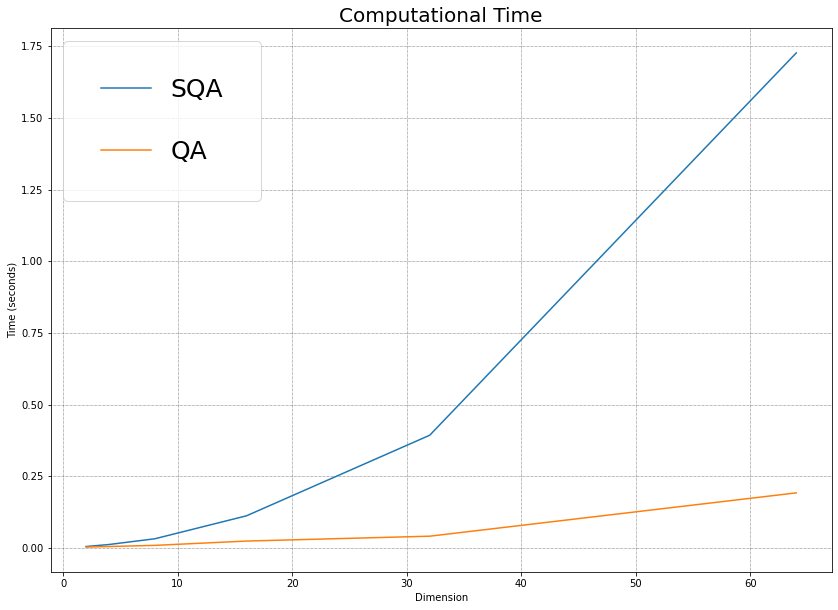

In [19]:
import time
import matplotlib.pyplot as plt

# Set parameters
accuracy = 4
a = 0
b = 2**accuracy
num_anneals = 10
num_reads = 10
seed = 42
dim_values = [2,4,8,16,32,64]

# Create empty lists to store results
anneal_times = []
q_anneal_times = []

# Loop over dimension values and run tests
for dim in dim_values:
    start_time = time.time()
    test_anneal(dim, accuracy, a, b, seed, num_anneals)
    anneal_times.append(time.time() - start_time)

    start_time = time.time()
    test_q_anneal(dim, accuracy, a, b, seed, num_reads)
    q_anneal_times.append(time.time() - start_time)

# Plot results
fig, ax1 = plt.subplots(figsize=(14,10))

ax1.set_xlabel('Dimension')
ax1.set_ylabel('Time (seconds)')
ax1.plot(dim_values, anneal_times, label='SQA')
ax1.plot(dim_values, q_anneal_times, label='QA')
ax1.grid(linestyle=':', linewidth='0.5', color='black')
plt.title("Computational Time", fontsize=20)
# plt.xlabel('Dimension', fontsize=16)
# plt.ylabel('Time (seconds)', fontsize=16)
ax1.legend(prop={'size':25}, borderpad=1.5, labelspacing=1.5)
plt.show()

Precision: 1.0 Range: [0,8)
Actual [4 7]
Computed [4. 7.]
Error =  0.0
Precision: 1.0 Range: [0,8)
Actual [5 3]
Computed [5. 3.]
Error =  0.0
Precision: 1.0 Range: [0,8)
Actual [0 7]
Computed [0. 7.]
Error =  0.0
Precision: 1.0 Range: [0,8)
Actual [2 0]
Computed [2. 0.]
Error =  0.0
Precision: 1.0 Range: [0,8)
Actual [2 6]
Computed [2. 6.]
Error =  0.0
Precision: 1.0 Range: [0,8)
Actual [4 7 5 0]
Computed [5. 7. 2. 2.]
Error =  3.7416573867739413
Precision: 1.0 Range: [0,8)
Actual [5 3 4 0]
Computed [6. 2. 3. 1.]
Error =  2.0
Precision: 1.0 Range: [0,8)
Actual [0 7 5 0]
Computed [4. 3. 1. 4.]
Error =  8.0
Precision: 1.0 Range: [0,8)
Actual [2 0 1 3]
Computed [0. 2. 3. 1.]
Error =  4.0
Precision: 1.0 Range: [0,8)
Actual [2 6 7 5]
Computed [3. 6. 4. 7.]
Error =  3.7416573867739413
Precision: 1.0 Range: [0,8)
Actual [4 7 5 0 3 3 3 7]
Computed [2. 7. 1. 7. 4. 4. 4. 3.]
Error =  9.38083151964686
Precision: 1.0 Range: [0,8)
Actual [5 3 4 0 7 1 3 5]
Computed [6. 2. 0. 5. 2. 6. 7. 0.]
Error = 

NameError: name 'conds' is not defined

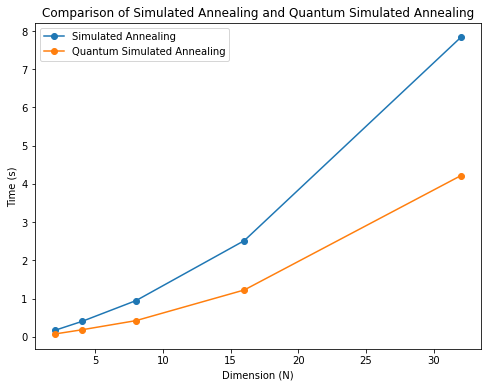

In [7]:
# Parameters
accuracy = 3
a = 0
b = 2**accuracy
num_anneals = 1000
num_reads = 1000
seeds = [0, 1, 2, 3, 4]
dims = [2, 4, 8, 16, 32]

# Test anneal
anneal_times = []
for dim in dims:
    dim_time = []
    for seed in seeds:
        start_time = time.time()
        test_anneal(dim, accuracy, a, b, seed, num_anneals)
        end_time = time.time()
        dim_time.append(end_time - start_time)
    anneal_times.append(sum(dim_time) / len(dim_time))

# Test q_anneal
q_anneal_times = []
for dim in dims:
    dim_time = []
    for seed in seeds:
        start_time = time.time()
        test_q_anneal(dim, accuracy, a, b, seed, num_reads)
        end_time = time.time()
        dim_time.append(end_time - start_time)
    q_anneal_times.append(sum(dim_time) / len(dim_time))

# Plot times
plt.figure(figsize=(8,6))
plt.plot(dims, anneal_times, '-o', label='Simulated Annealing')
plt.plot(dims, q_anneal_times, '-o', label='Quantum Simulated Annealing')
plt.xlabel('Dimension (N)')
plt.ylabel('Time (s)')
plt.title('Comparison of Simulated Annealing and Quantum Simulated Annealing')
plt.legend();

# # Print condition numbers
# for i, dim in enumerate(dims):
#     print(f"Dimension {dim}: Condition number = {conds[i]}")

## These test matrices are extremely ill-conditioned

In [15]:
dims = [2, 4, 8, 16, 32, 64, 128] # Example list of dim values
for dim in dims:
    A = np.arange(dim**2).reshape((dim,dim))
    cond = np.linalg.cond(A)
    print(f"Condition number of A with dim={dim}: {cond}")

Condition number of A with dim=2: 6.8541019662496865
Condition number of A with dim=4: 2.568988929962167e+17
Condition number of A with dim=8: 3.6759232197913667e+18
Condition number of A with dim=16: 1.0674366404262884e+20
Condition number of A with dim=32: 3.5589830650534566e+20
Condition number of A with dim=64: 5.634403718595399e+22
Condition number of A with dim=128: 5.17141690898273e+21


## Conditioned Matrices

In [5]:
def generate_random_matrix(dim):
    while True:
        # Generate a random matrix
        B = np.random.rand(dim, dim)

        # Compute the condition number
        cond = np.linalg.cond(B)

        # Check if the condition number is less than 10
        if cond < 100:
            return B

In [6]:
def test_anneal1(dim, accuracy, a, b, seed, num_anneals=None):
    np.random.seed(seed)
    
    A = np.random.rand(dim, dim)
    while np.linalg.cond(A) > 1000:
        A = np.random.rand(dim, dim)
    C = np.random.randint(b, size=dim)
    B = A @ C
    sol = anneal(A, B, accuracy, a, b, num_anneals)
    
    print('Actual', C);
    print('Computed', sol);
    print('Error = ', np.linalg.norm(C-sol));
    return sol, np.linalg.cond(A)


def test_q_anneal1(dim, accuracy, a, b, seed, num_reads=None):
    np.random.seed(seed)
    
    A = np.random.rand(dim, dim)
    while np.linalg.cond(A) > 1000:
        A = np.random.rand(dim, dim)
    C = np.random.randint(b, size=dim)
    B = A @ C
    sol = q_anneal(A, B, accuracy, a, b, num_reads)
    
    print('Actual', C);
    print('Computed', sol);
    print('Error = ', np.linalg.norm(C-sol));
    return sol, np.linalg.cond(A)

Precision: 2.0 Range: [-8,8)
Actual [6 1]
Computed [4. 2.]
Error =  2.23606797749979
Precision: 2.0 Range: [-8,8)
Actual [3 1 5 4]
Computed [2. 2. 4. 4.]
Error =  1.7320508075688772
Precision: 2.0 Range: [-8,8)
Actual [3 3 3 4 0 4 6 4]
Computed [2. 2. 2. 4. 2. 2. 6. 6.]
Error =  3.872983346207417
Precision: 2.0 Range: [-8,8)
Actual [6 5 1 2 7 5 7 1 7 6 5 6 1 6 2 1]
Computed [4. 4. 0. 2. 6. 6. 6. 2. 6. 6. 4. 6. 2. 4. 4. 6.]
Error =  6.782329983125268
Precision: 2.0 Range: [-8,8)
Actual [0 2 3 2 3 1 4 3 0 2 1 0 1 4 6 2 5 2 7 4 2 7 5 3 1 5 0 4 3 0 0 4]
Computed [ 2.  4.  6.  2.  4. -2.  6.  6.  2.  2.  4.  0. -2.  0.  6.  0.  6.  0.
  6.  4.  2.  6.  6.  6.  2.  4.  2.  2.  0. -2.  0.  4.]
Error =  11.045361017187261
Precision: 2.0 Range: [-8,8)
Actual [0 1 7 0 1 7 3 6 3 1 0 2 3 3 7 5 2 1 6 0 5 1 4 6 3 4 3 3 4 6 7 4 1 5 5 4 1
 7 5 1 7 1 3 5 7 5 3 4 3 5 5 6 7 4 3 7 0 7 0 4 3 3 1 5]
Computed [ 0.  0.  6.  2.  6.  6.  2.  6.  4.  0.  2.  2.  6.  0.  6.  4. -2.  2.
  4.  0.  4.  4.  4.  6.  4

C:\Users\Max Thomson\AppData\Local\Temp\ipykernel_21720\3523009429.py:46: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(anneal_times, dims, '-o', label='Simulated Annealing', color='C0', marker='o', linewidth=2)
C:\Users\Max Thomson\AppData\Local\Temp\ipykernel_21720\3523009429.py:47: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(q_anneal_times, dims, '-o', label='Quantum Simulated Annealing', color='C1', marker='o', linewidth=2)


NameError: name 'ax2' is not defined

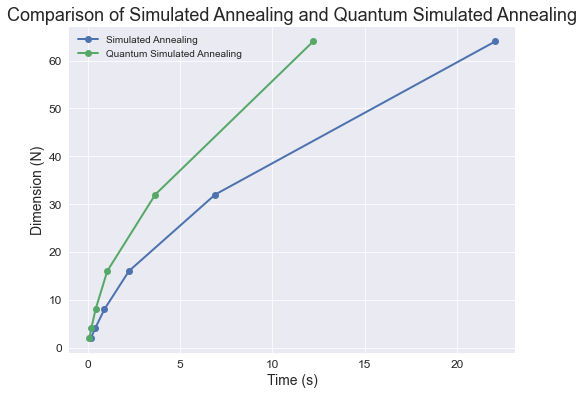

In [12]:
# Parameters
accuracy = 3
a = -2**accuracy
b = 2**accuracy
num_anneals = 1000
num_reads = 1000
seeds = [42]
dims = [2, 4, 8, 16, 32, 64]

# Test anneal
anneal_times = []
conds = []
for dim in dims:
    dim_time = []
    dim_conds = []
    for seed in seeds:
        start_time = time.time()
        _, cond = test_anneal1(dim, accuracy, a, b, seed, num_anneals)
        end_time = time.time()
        dim_time.append(end_time - start_time)
        dim_conds.append(cond)
    anneal_times.append(sum(dim_time) / len(dim_time))
    conds.append(sum(dim_conds) / len(dim_conds))

# Test q_anneal
q_anneal_times = []
q_conds = []
for dim in dims:
    dim_time = []
    dim_conds = []
    for seed in seeds:
        start_time = time.time()
        _, q_cond = test_q_anneal1(dim, accuracy, a, b, seed, num_reads)
        end_time = time.time()
        dim_time.append(end_time - start_time)
        dim_conds.append(cond)
    q_anneal_times.append(sum(dim_time) / len(dim_time))
    q_conds.append(sum(dim_conds) / len(dim_conds))

# Plot times
# Set plot style
plt.style.use('seaborn')

# Plot times
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(anneal_times, dims, '-o', label='Simulated Annealing', color='C0', marker='o', linewidth=2)
ax.plot(q_anneal_times, dims, '-o', label='Quantum Simulated Annealing', color='C1', marker='o', linewidth=2)

# Add grid, title, and axis labels
ax.grid(alpha=0.8)
ax.set_title('Comparison of Simulated Annealing and Quantum Simulated Annealing', fontsize=18)
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_ylabel('Dimension (N)', fontsize=14)

# Add legend
ax.legend()

# Increase font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Show plot
plt.show()

# Print condition numbers
for i, dim in enumerate(dims):
    print(f"Dimension {dim}: Condition number (A) = {conds[i]:.2f}, Condition number (B) = {q_conds[i]:.2f}")

### Percentage Error & Residual for Random Matrices [0,1)

In [5]:
def anneal2(A, C, accuracy, a, b, num_anneals=None):
    B = A @ C
    sol = anneal(A, B, accuracy, a, b, num_anneals)
    
    print('Actual', C)
    print('Computed', sol)
    print('Error = ', np.linalg.norm(C-sol))
    return sol


def q_anneal2(A, C, accuracy, a, b, num_anneals=None):
    B = A @ C
    sol = q_anneal(A, B, accuracy, a, b, num_reads)
    
    print('Actual', C)
    print('Computed', sol)
    print('Error = ', np.linalg.norm(C-sol))
    return sol

Precision: 1.0 Range: [0,16)
Actual [ 6 14]
Computed [ 6. 14.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 6 14]
Computed [ 6. 14.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [5 6 2 4]
Computed [5. 6. 2. 4.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [5 6 2 4]
Computed [5. 6. 2. 4.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 5  8  8  1  4 10 15 13]
Computed [ 5.  8.  8.  1.  4. 10. 15. 13.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 5  8  8  1  4 10 15 13]
Computed [ 5.  8.  8.  1.  4. 10. 15. 13.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 2  4 15 12  9  3 12  4  7  4  4  7 11 15 10  8]
Computed [ 2.  5. 15. 13.  9.  1. 11.  3.  8.  3.  5.  7. 11. 14. 11.  9.]
Error =  3.7416573867739413
Precision: 1.0 Range: [0,16)
Actual [ 2  4 15 12  9  3 12  4  7  4  4  7 11 15 10  8]
Computed [ 2.  4. 15. 12.  8.  3. 13.  4.  6.  4.  4.  7. 12. 15. 11.  7.]
Error =  2.449489742783178
Precision: 1.0 Range: [0,16)
Actual [ 6 15  3  0  1 15 12 15 15  4  3  

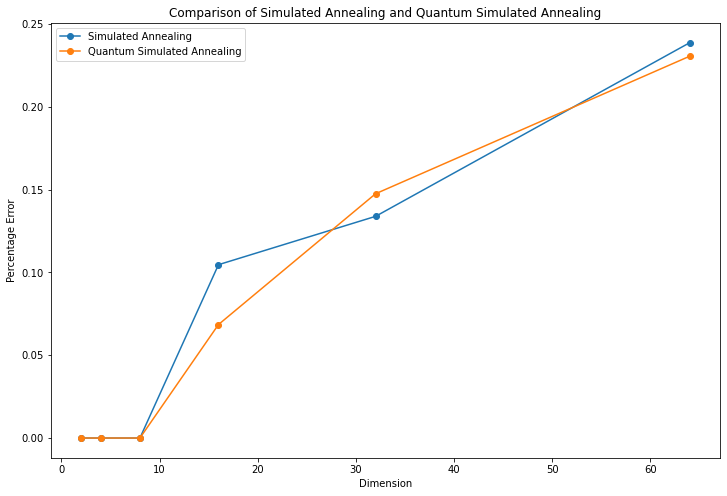

In [8]:
# Parameters
accuracy = 4
a = 0
b = 2**accuracy
num_anneals = 10000
num_reads = 10000
seeds = [42]
dims = [2,4,8,16,32,64]

# Compare anneal and q_anneal percentage errors
anneal_errors = []
q_anneal_errors = []
for dim in dims:
    anneal_error = []
    q_anneal_error = []
    for seed in seeds:
        A = np.random.rand(dim, dim)
        C = np.random.randint(b, size=dim)
        anneal_sol = anneal2(A, C, accuracy, a, b, num_anneals)
        q_anneal_sol = q_anneal2(A, C, accuracy, a, b, num_reads)
        anneal_error.append(np.linalg.norm(C - anneal_sol) / np.linalg.norm(C))
        q_anneal_error.append(np.linalg.norm(C - q_anneal_sol) / np.linalg.norm(C))
    anneal_errors.append(sum(anneal_error) / len(anneal_error))
    q_anneal_errors.append(sum(q_anneal_error) / len(q_anneal_error))

# Plot percentage errors
plt.figure(figsize=(12,8))
plt.plot(dims, anneal_errors, '-o', label='Simulated Quantum Annealing')
plt.plot(dims, q_anneal_errors, '-o', label='Quantum Simulated Annealing')
plt.xlabel('Dimension')
plt.ylabel('Percentage Error')
plt.title('Comparison of Simulated Annealing and Quantum Simulated Annealing')
plt.legend();

Precision: 1.0 Range: [0,16)
Actual [ 0 10]
Computed [ 0. 10.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 0 10]
Computed [ 0. 10.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [10 13 10  6]
Computed [10. 13. 10.  6.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [10 13 10  6]
Computed [10. 13. 10.  6.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 1  4  6  3  2 12  0  9]
Computed [ 1.  4.  6.  3.  2. 12.  0.  9.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 1  4  6  3  2 12  0  9]
Computed [ 1.  4.  6.  3.  2. 12.  0.  9.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [14  9  8  0 15  7  0  0  5  3  9 15  4 15  5 15]
Computed [15. 10.  9.  0. 15.  8.  0.  0.  5.  2.  8. 14.  4. 15.  5. 14.]
Error =  2.8284271247461903
Precision: 1.0 Range: [0,16)
Actual [14  9  8  0 15  7  0  0  5  3  9 15  4 15  5 15]
Computed [14. 10.  8.  0. 15.  7.  0.  0.  5.  3.  9. 15.  4. 14.  5. 15.]
Error =  1.4142135623730951
Precision: 1.0 Range: [0,16)
Actual [ 3  3  8  9 12  1

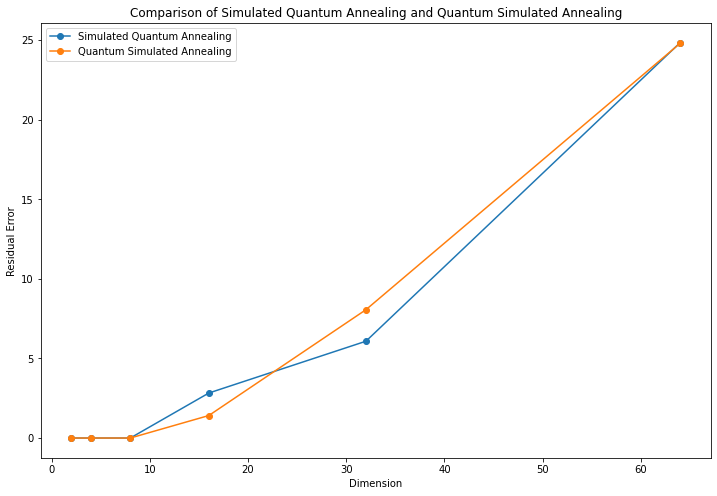

In [9]:
# Parameters
accuracy = 4
a = 0
b = 2**accuracy
num_anneals = 10000
num_reads = 10000
seeds = [42]
dims = [2,4,8,16,32,64]

# Compare residual
anneal_errors = []
q_anneal_errors = []
for dim in dims:
    anneal_error = []
    q_anneal_error = []
    for seed in seeds:
        A = np.random.rand(dim, dim)
        C = np.random.randint(b, size=dim)
        anneal_sol = anneal2(A, C, accuracy, a, b, num_anneals)
        q_anneal_sol = q_anneal2(A, C, accuracy, a, b, num_reads)
        anneal_error.append(np.linalg.norm(C - anneal_sol))
        q_anneal_error.append(np.linalg.norm(C - q_anneal_sol))
    anneal_errors.append(anneal_error)
    q_anneal_errors.append(q_anneal_error)

# Plot residual
plt.figure(figsize=(12,8))
plt.plot(dims, anneal_errors, '-o', label='Simulated Quantum Annealing')
plt.plot(dims, q_anneal_errors, '-o', label='Quantum Simulated Annealing')
plt.xlabel('Dimension')
plt.ylabel('Residual Error')
plt.title('Comparison of Simulated Quantum Annealing and Quantum Simulated Annealing')
plt.legend();

Precision: 1.0 Range: [0,16)
Actual [7]
Computed [7.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [7]
Computed [7.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [3 3]
Computed [3. 3.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [3 3]
Computed [3. 3.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [13  4  5]
Computed [13.  4.  5.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [13  4  5]
Computed [13.  4.  5.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 5  2  3 15]
Computed [ 5.  2.  3. 15.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 5  2  3 15]
Computed [ 5.  2.  3. 15.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 1  5 11  0 13]
Computed [ 1.  5. 11.  0. 13.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 1  5 11  0 13]
Computed [ 1.  5. 11.  0. 13.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 8 11  0 14 12 15]
Computed [ 8. 11.  0. 14. 12. 15.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 8 11  0 14 12 15]
Computed [ 8. 11.  0. 

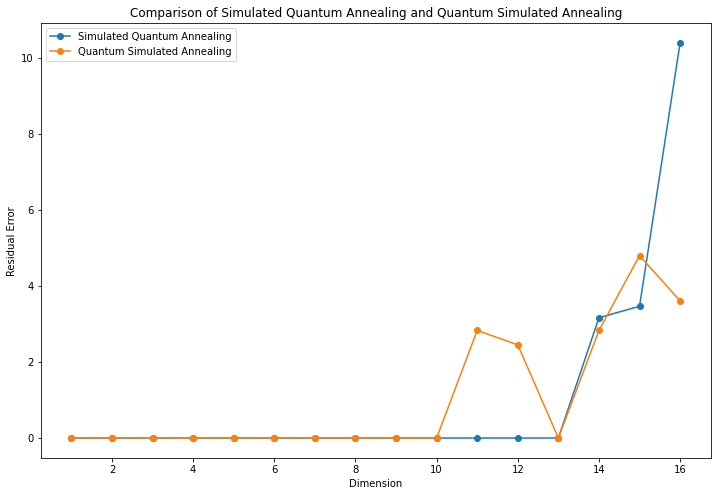

In [7]:
# Parameters
accuracy = 4
a = 0
b = 2**accuracy
num_anneals = 10000
num_reads = 10000
seeds = [42]
dims = [i for i in range(1, 17)]

# Compare residual
anneal_errors = []
q_anneal_errors = []
for dim in dims:
    anneal_error = []
    q_anneal_error = []
    for seed in seeds:
        A = np.random.rand(dim, dim)
        C = np.random.randint(b, size=dim)
        anneal_sol = anneal2(A, C, accuracy, a, b, num_anneals)
        q_anneal_sol = q_anneal2(A, C, accuracy, a, b, num_reads)
        anneal_error.append(np.linalg.norm(C - anneal_sol))
        q_anneal_error.append(np.linalg.norm(C - q_anneal_sol))
    anneal_errors.append(anneal_error)
    q_anneal_errors.append(q_anneal_error)

# Plot residual
plt.figure(figsize=(12,8))
plt.plot(dims, anneal_errors, '-o', label='Simulated Quantum Annealing')
plt.plot(dims, q_anneal_errors, '-o', label='Quantum Simulated Annealing')
plt.xlabel('Dimension')
plt.ylabel('Residual Error')
plt.title('Comparison of Simulated Quantum Annealing and Quantum Simulated Annealing')
plt.legend();

In [25]:
def threshold_test(dim_range, accuracy, a, b, num_anneals=None, num_reads=None, seed=42):
    anneal_errors = []
    q_anneal_errors = []
    dims = []
    
    # Calculate the threshold x value
    x = None
    for dim in dim_range:
        np.random.seed(seed)
        A = np.random.rand(dim, dim)
        while np.linalg.cond(A) > 1000:
            A = np.random.rand(dim, dim)
        C = np.random.randint(b, size=dim)
        B = A @ C
        q_sol, q_cond = test_q_anneal1(dim, accuracy, a, b, seed, num_reads)
        sol, cond = test_anneal1(dim, accuracy, a, b, seed, num_anneals)
        q_sol = q_sol.reshape(dim)
        sol = sol.reshape(dim)
        q_error = np.linalg.norm(q_sol - C)
        error = np.linalg.norm(sol - C)
        if error != 0 and x is None:
            x = dim
        if q_error != 0 and x is None:
            x = dim
        q_anneal_errors.append(q_error)
        anneal_errors.append(error)
        dims.append(dim)
        if error == 0:
            last_zero_dim = dim
     
    # Plot the errors and mark the threshold x value
    plt.plot(dims, q_anneal_errors, 'r', label='Q Annealing Error')
    plt.plot(dims, anneal_errors, 'b', label='Annealing Error')
    if x is not None:
        plt.axvline(x=last_zero_dim, linestyle='--', color='r', label='Threshold')
    plt.legend(loc='upper left')
    plt.xlabel('Dimension')
    plt.ylabel('Error')
    plt.show()
    
    return dims, anneal_errors, q_anneal_errors


Precision: 1.0 Range: [0,16)
Actual [6 9]
Computed [6. 9.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [6 9]
Computed [6. 9.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [11  9  5 12]
Computed [11.  9.  5. 12.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [11  9  5 12]
Computed [11.  9.  5. 12.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 8  9  4  1  3 11]
Computed [ 8.  9.  4.  1.  3. 11.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [ 8  9  4  1  3 11]
Computed [ 8.  9.  4.  1.  3. 11.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [11 11 11 12  8 12 14 12]
Computed [11. 11. 11. 12.  8. 12. 14. 12.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [11 11 11 12  8 12 14 12]
Computed [11. 11. 11. 12.  8. 12. 14. 12.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [14 15  6  0  3 12 15  3 13  4]
Computed [14. 15.  6.  0.  3. 12. 15.  3. 13.  4.]
Error =  0.0
Precision: 1.0 Range: [0,16)
Actual [14 15  6  0  3 12 15  3 13  4]
Computed [14. 15.  6.  0.  3. 12

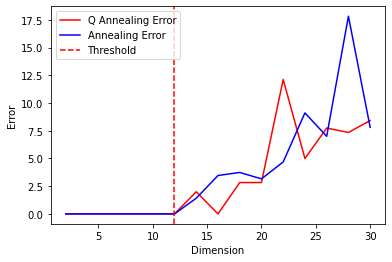

In [26]:
dim_range = range(2, 32, 2)
accuracy = 4
a = 0
b = 2**accuracy
num_anneals = 10000
num_reads = 10000
seed = 42

threshold, q_threshold, x = threshold_test(dim_range, accuracy, a, b, num_anneals, num_reads, seed)

### Test Matrices
- Identity
- Symmetric

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def test_anneal_eye(dim, accuracy, a, b, seed, num_anneals=None):
    np.random.seed(seed)

    A = np.eye(dim)
    C = np.random.randint(b,size=dim)
    B = A@C
    sol = anneal(A,B,accuracy,a,b, num_anneals)
    
    error = np.linalg.norm(C-sol)
    return error

def test_q_anneal_eye(dim, accuracy, a, b, seed, num_reads=None):
    np.random.seed(seed)

    A = np.eye(dim)
    C = np.random.randint(b,size=dim)
    B = A@C
    sol = q_anneal(A,B,accuracy,a,b, num_reads)
    
    error = np.linalg.norm(C-sol)
    return error

In [13]:
def plot_errors(dim_range, accuracy, a, b, num_anneals=None, num_reads=None, seed=42):
    anneal_errors = []
    q_anneal_errors = []
    dims = []
    for dim in dim_range:
        anneal_error = test_anneal_eye(dim, accuracy, a, b, seed, num_anneals)
        q_anneal_error = test_q_anneal_eye(dim, accuracy, a, b, seed, num_reads)
        anneal_errors.append(anneal_error)
        q_anneal_errors.append(q_anneal_error)
        dims.append(dim)
     
    # Plot the errors
    plt.plot(dims, anneal_errors, 'r', label='SQA', marker='o')
    plt.plot(dims, q_anneal_errors, 'b', label='QSA', marker='o')
    plt.legend(loc='upper left')
    plt.xlabel('Dimension')
    plt.ylabel('Error')
    plt.show()

    print(anneal_errors)
    print(q_anneal_errors)

Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0

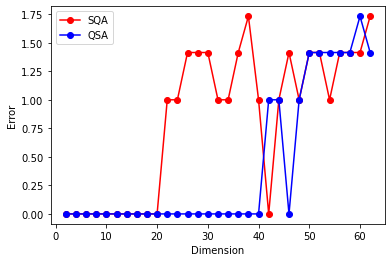

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.4142135623730951, 1.4142135623730951, 1.4142135623730951, 1.0, 1.0, 1.4142135623730951, 1.7320508075688772, 1.0, 0.0, 1.0, 1.4142135623730951, 1.0, 1.4142135623730951, 1.4142135623730951, 1.0, 1.4142135623730951, 1.4142135623730951, 1.4142135623730951, 1.7320508075688772]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.4142135623730951, 1.4142135623730951, 1.4142135623730951, 1.4142135623730951, 1.4142135623730951, 1.7320508075688772, 1.4142135623730951]


In [15]:
dim_range = range(2, 64, 2)
accuracy = 5
a = 0
b = 2**accuracy
num_anneals = 1000
num_reads = 1000
seed = 42

plot_errors(dim_range, accuracy, a, b, num_anneals, num_reads, seed)

### Symmetric

In [92]:
def test_anneal_sym(dim, accuracy, a, b, seed, num_anneals=None):
    np.random.seed(seed)

    A = np.random.randint(b,size=(dim,dim))
    A = (A + A.T)/2  # make A symmetric
    C = np.random.randint(b,size=dim)
    B = A@C
    sol = anneal(A,B,accuracy,a,b, num_anneals)
    
    error = np.linalg.norm(C-sol)
    return error

def test_q_anneal_sym(dim, accuracy, a, b, seed, num_reads=None):
    np.random.seed(seed)

    A = np.random.randint(b,size=(dim,dim))
    A = (A + A.T)/2  # make A symmetric
    C = np.random.randint(b,size=dim)
    B = A@C
    sol = q_anneal(A,B,accuracy,a,b, num_reads)
    
    error = np.linalg.norm(C-sol)
    return error

In [99]:
def plot_errors_sym(dim_range, accuracy, a, b, num_anneals=None, num_reads=None, seed=42):
    anneal_errors = []
    q_anneal_errors = []
    dims = []
    for dim in dim_range:
        anneal_error = test_anneal_sym(dim, accuracy, a, b, seed, num_anneals)
        q_anneal_error = test_q_anneal_sym(dim, accuracy, a, b, seed, num_reads)
        anneal_errors.append(anneal_error)
        q_anneal_errors.append(q_anneal_error)
        dims.append(dim)
     
    # Plot the errors
    plt.plot(dims, q_anneal_errors, 'r', label='Q Annealing Error', marker='o')
    plt.plot(dims, anneal_errors, 'b', label='Annealing Error', marker='o')
    plt.legend(loc='upper left')
    plt.xlabel('Dimension')
    plt.ylabel('Error')
    plt.show()

    print(anneal_errors)
    print(q_anneal_errors)

In [ ]:
dim_range = range(2, 32, 2)
accuracy = 4
a = 0
b = 2**accuracy
num_anneals = 10000
num_reads = 10000
seed = 42

plot_errors(dim_range, accuracy, a, b, num_anneals, num_reads, seed)

Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0

### Identity Matrix - Time

In [16]:
def plot_time_vs_dim_eye(accuracy, a, b, num_anneals, num_reads, seeds, dims):
    # Test anneal
    anneal_times = []
    for dim in dims:
        dim_time = []
        dim_conds = []
        for seed in seeds:
            np.random.seed(seed)
            A = np.random.randint(a, b, size=(dim, dim))
            B = np.random.randint(a, b, size=dim)
            start_time = time.time()
            test_anneal_eye(dim, accuracy, a, b, seed, num_anneals=num_anneals)
            end_time = time.time()
            dim_time.append(end_time - start_time)
        anneal_times.append(sum(dim_time) / len(dim_time))

    # Test q_anneal
    q_anneal_times = []
    for dim in dims:
        dim_time = []
        dim_conds = []
        for seed in seeds:
            np.random.seed(seed)
            A = np.random.randint(a, b, size=(dim, dim))
            B = np.random.randint(a, b, size=dim)
            test_q_anneal_eye(dim, accuracy, a, b, seed, num_reads=num_reads)
            end_time = time.time()
            dim_time.append(end_time - start_time)
        q_anneal_times.append(sum(dim_time) / len(dim_time))

    # Plot times
    plt.plot(dims, anneal_times, label='Simulated Quantum Annealing', color='C0', marker='o', linewidth=2)
    plt.plot(dims, q_anneal_times, label='Quantum Simulated Annealing', color='C1', marker='o', linewidth=2)

    # Add grid, title, and axis labels
    plt.grid(alpha=0.8)
    plt.title('Comparison of Simulated Annealing and Quantum Simulated Annealing', fontsize=18)
    plt.xlabel('Dimension (N)', fontsize=14)
    plt.ylabel('Time (s)', fontsize=14)

    # Add legend
    plt.legend()

    # Increase font size of tick labels
    plt.tick_params(axis='both', which='major', labelsize=12)

    # Show plot
    plt.show()

Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)
Precision: 1.0 Range: [0,32)


C:\Users\Max Thomson\AppData\Local\Temp\ipykernel_15324\1765705277.py:32: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(dims, anneal_times, '-o', label='Simulated Annealing', color='C0', marker='o', linewidth=2)
C:\Users\Max Thomson\AppData\Local\Temp\ipykernel_15324\1765705277.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(dims, q_anneal_times, '-o', label='Quantum Simulated Annealing', color='C1', marker='o', linewidth=2)


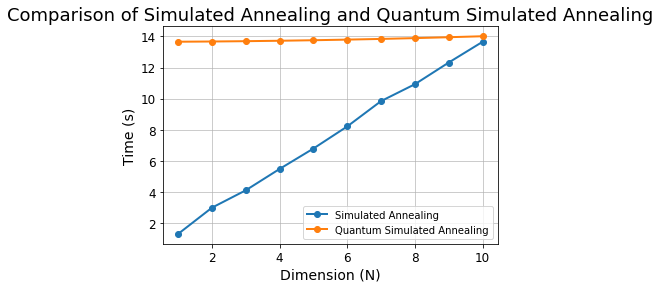

In [21]:
accuracy = 5
a = 0
b = 2**accuracy
num_anneals = 10000
num_reads = 100
seeds = [42]
dims = [1,2,3,4,5,6,7,8,9,10]

plot_time_vs_dim_eye(accuracy, a, b, num_anneals, num_reads, seeds, dims)

## GEPP vs Quantum Annealing

In [8]:
# Function to compute Ax = B using numpy
def classical_solve(A, B):
    return np.linalg.solve(A, B)

def GEPP(A, B):
    # Get the number of rows and columns
    n, m = A.shape
    
    # Augment the matrix A with B
    AB = np.hstack((A, B.reshape(n,1)))
    
    # For each pivot row
    for i in range(n):
        # Find the row with the largest absolute value in the pivot column
        max_idx = i + np.argmax(np.abs(AB[i:,i]))
        
        # Swap the pivot row with the row with the largest absolute value in the pivot column
        AB[[i, max_idx]] = AB[[max_idx, i]]
        
        # For each row below the pivot row
        for j in range(i+1, n):
            # Calculate the row multiplier
            m = AB[j,i] / AB[i,i]
            
            # Subtract the pivot row multiplied by the row multiplier from the current row
            AB[j,:] = AB[j,:] - m * AB[i,:].astype(np.float64)
    
    # Back substitute to solve for x
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (AB[i,-1] - np.dot(AB[i,:-1], x)) / AB[i,i]
    
    return x

# Function to compute time taken for quantum annealing and numpy methods
def time_q_anneal(dim, accuracy, a, b, seed, num_reads=None):
    np.random.seed(seed)

    A = np.arange(dim**2).reshape((dim,dim))
    Q, R = np.linalg.qr(A)
    C = np.random.randint(b, size=dim)
    B = Q @ C
    
    # Compute time taken for quantum annealing method
    start_time_qa = time.time()
    sol_qa = q_anneal(Q, B, accuracy, a, b, num_reads)
    end_time_qa = time.time()
    time_qa = end_time_qa - start_time_qa

    # Compute time taken for classical numpy method
    start_time_np = time.time()
    sol_np = GEPP(Q, B)
    end_time_np = time.time()
    time_np = end_time_np - start_time_np

    # Return time taken for both methods
    return time_qa, time_np

Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)
Precision: 1.0 Range: [0,16)


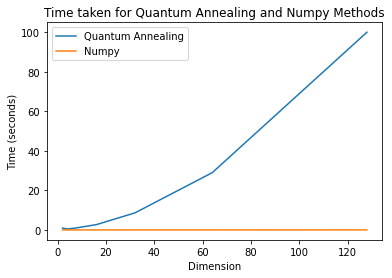

In [52]:
# Range of dimensions to test
dimensions = [2,4,8,16,32,64,128]

# Set other parameters
accuracy = 4
a = 0
b = 2**accuracy
seed = 1

# Lists to store time taken for each method for each dimension
times_qa = []
times_np = []

# Compute time taken for each dimension
for dim in dimensions:
    time_qa, time_np = time_q_anneal(dim, accuracy, a, b, seed)
    times_qa.append(time_qa)
    times_np.append(time_np)

# Plot the results
plt.plot(dimensions, times_qa, label='Quantum Annealing')
plt.plot(dimensions, times_np, label='Numpy')
plt.xlabel('Dimension')
plt.ylabel('Time (seconds)')
plt.title('Time taken for Quantum Annealing and Numpy Methods')
plt.legend()
plt.show()

### Function to Plot

In [5]:
def plot_time_vs_dim(dim_range, accuracy, a, b, seed, num_anneals, num_reads):
    anneal_times = []
    q_anneal_times = []
    gepp_times = []
    for dim in dim_range:
        np.random.seed(seed)

        A = np.arange(dim**2).reshape((dim,dim))
        Q, R = np.linalg.qr(A)
        C = np.random.randint(b,size=dim)
        B = Q@C
        
        start_time = time.time()
        sol = anneal(Q,B,accuracy,a,b, num_anneals)
        end_time = time.time()
        anneal_times.append(end_time - start_time)
        
        
        start_time = time.time()
        sol_q = q_anneal(Q,B,accuracy,a,b, num_reads)
        end_time = time.time()
        q_anneal_times.append(end_time - start_time)
        

        start_time = time.time()
        x = GEPP(Q, B)
        end_time = time.time()
        gepp_times.append(end_time - start_time)
        
        print(f"Dimension {dim}: SQA Time = {anneal_times[-1]}, Q-Anneal Time = {q_anneal_times[-1]}, GEPP Time = {gepp_times[-1]}")
    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Dimension', fontsize=14)
    ax1.set_ylabel('Time (seconds)', fontsize=14)

    ax1.plot(dim_range, anneal_times, marker='o', label = 'SA')
    ax1.plot(dim_range, q_anneal_times, marker='o', label='SQA')
    ax1.plot(dim_range, gepp_times, marker='o', label='GEPP')
    ax1.grid(linestyle=':', linewidth='0.5', color='black')
    ax1.legend(loc='upper left', prop={'size': 12})
    plt.title('Well-conditioned', fontsize=18)
    plt.savefig('well-cond1.pdf')
    plt.show()

Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 2: SQA Time = 2.0172791481018066, Q-Anneal Time = 0.9542903900146484, GEPP Time = 0.0
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 4: SQA Time = 9.944677114486694, Q-Anneal Time = 0.4964427947998047, GEPP Time = 0.0
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 8: SQA Time = 19.601953506469727, Q-Anneal Time = 1.19626784324646, GEPP Time = 0.0
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 16: SQA Time = 40.97341251373291, Q-Anneal Time = 3.065915584564209, GEPP Time = 0.0010004043579101562
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 32: SQA Time = 87.37960863113403, Q-Anneal Time = 9.25173020362854, GEPP Time = 0.0010001659393310547
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 64: SQA Time = 197.23132061958313, Q-Anneal Time = 31.650763034820557, GEPP Time = 0.006016254425048828


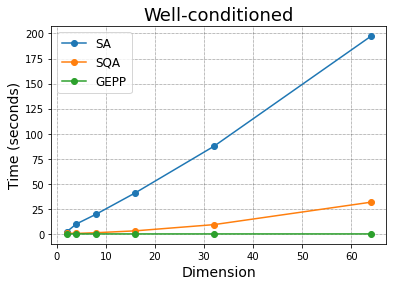

In [26]:
dim_range = [2,4,8,16,32,64]
accuracy = 4
a = -8
b = 8
seed = 42

plot_time_vs_dim(dim_range, accuracy, a, b, seed, num_anneals = 10000, num_reads=10000)

In [6]:
def plot_time_vs_dimA(dim_range, accuracy, a, b, seed, num_anneals, num_reads):
    anneal_times = []
    q_anneal_times = []
    gepp_times = []
    for dim in dim_range:
        np.random.seed(seed)

        A = np.arange(dim**2).reshape((dim,dim))
        C = np.random.randint(b,size=dim)
        B = A@C
        
        start_time = time.time()
        sol = anneal(A,B,accuracy,a,b, num_anneals)
        end_time = time.time()
        anneal_times.append(end_time - start_time)
        
        
        start_time = time.time()
        sol_q = q_anneal(A,B,accuracy,a,b, num_reads)
        end_time = time.time()
        q_anneal_times.append(end_time - start_time)
        

        start_time = time.time()
        x = GEPP(A, B)
        end_time = time.time()
        gepp_times.append(end_time - start_time)
        
        print(f"Dimension {dim}: SA Time = {anneal_times[-1]}, SQA Time = {q_anneal_times[-1]}, GEPP Time = {gepp_times[-1]}")
    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Dimension', fontsize=14)
    ax1.set_ylabel('Time (seconds)', fontsize=14)

    ax1.plot(dim_range, anneal_times, marker='o', label = 'SA')
    ax1.plot(dim_range, q_anneal_times, marker='o', label='SQA')
    ax1.plot(dim_range, gepp_times, marker='o', label='GEPP')
    ax1.grid(linestyle=':', linewidth='0.5', color='black')

    ax1.legend(loc='upper left', prop={'size': 12})

    plt.title('Ill-conditioned', fontsize=18)
    plt.savefig('ill-cond1.pdf')
    plt.show()

Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 2: SA Time = 2.3943166732788086, SQA Time = 1.145251989364624, GEPP Time = 0.0
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 4: SA Time = 5.348439693450928, SQA Time = 2.437985897064209, GEPP Time = 0.0
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)


C:\Users\Max Thomson\AppData\Local\Temp\ipykernel_17940\360343342.py:23: RuntimeWarning: invalid value encountered in long_scalars
  m = AB[j,i] / AB[i,i]
C:\Users\Max Thomson\AppData\Local\Temp\ipykernel_17940\360343342.py:31: RuntimeWarning: invalid value encountered in double_scalars
  x[i] = (AB[i,-1] - np.dot(AB[i,:-1], x)) / AB[i,i]


Dimension 8: SA Time = 12.632444381713867, SQA Time = 5.9433300495147705, GEPP Time = 0.0010001659393310547
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 16: SA Time = 34.7009801864624, SQA Time = 17.483960390090942, GEPP Time = 0.0010001659393310547
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 32: SA Time = 108.4912166595459, SQA Time = 58.14110612869263, GEPP Time = 0.0020003318786621094
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 64: SA Time = 291.58774638175964, SQA Time = 153.84943675994873, GEPP Time = 0.006001710891723633


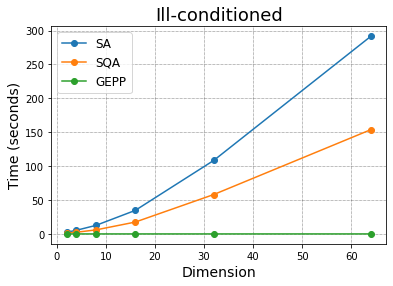

In [9]:
dim_range = [2,4,8,16,32,64]
accuracy = 4
a = -8
b = 8
seed = 42

plot_time_vs_dimA(dim_range, accuracy, a, b, seed, num_anneals = 10000, num_reads=10000)

In [11]:
import numpy as np

# Set up parameters
accuracy = 4
a = -8
b = 8
num_anneals = 6
num_reads = 10000


# Generate random matrices and calculate condition number and error for each
for i in range(5):
    A = np.random.rand(3, 3)
    C = np.random.randint(b, size=3)
    B = A@C
    cond_num = np.linalg.cond(A)
    
    # Anneal method
    anneal_sol = anneal(A,B,accuracy,a,b,num_anneals)
    anneal_error = np.linalg.norm(C - anneal_sol)
    
    # Q_anneal method
    q_anneal_sol = q_anneal(A,B,accuracy,a,b,num_reads)
    q_anneal_error = np.linalg.norm(C - q_anneal_sol)
    
    # Print results
    print("Matrix", i+1, ":")
    print(np.round(A,4))
    print(f"Condition number: {cond_num:.4f}")
    print(f"Anneal error: {anneal_error:.4f}")
    print(f"Q_anneal error: {q_anneal_error:.4f}")
    print("-----------------------------------")

Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Matrix 1 :
[[0.8563 0.4045 0.8878]
 [0.8509 0.9356 0.7853]
 [0.669  0.5807 0.3723]]
Condition number: 14.5048
Anneal error: 1.4142
Q_anneal error: 0.0000
-----------------------------------
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Matrix 2 :
[[0.2839 0.3054 0.4856]
 [0.4484 0.9945 0.1759]
 [0.0181 0.4939 0.1788]]
Condition number: 6.7608
Anneal error: 0.0000
Q_anneal error: 0.0000
-----------------------------------
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Matrix 3 :
[[0.7209 0.3081 0.5425]
 [0.5088 0.6363 0.2505]
 [0.5899 0.9789 0.4867]]
Condition number: 16.0157
Anneal error: 0.0000
Q_anneal error: 0.0000
-----------------------------------
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Matrix 4 :
[[0.3501 0.6451 0.6689]
 [0.8642 0.2302 0.4992]
 [0.572  0.7686 0.0436]]
Condition number: 3.4269
Anneal error: 0.0000
Q_anneal error: 0.0000
-----------------------------------
Precision:

In [12]:
def generate_matrix_with_bounded_cond_num(n, min_val, max_val, prev_cond_num=1):
    A = None
    while True:
        U, S, V = np.linalg.svd(np.random.rand(n, n))
        S = np.clip(S, min_val, max_val)
        A = U @ np.diag(S) @ V
        cond_num = np.linalg.cond(A)
        if cond_num >= prev_cond_num:
            break
        prev_cond_num = cond_num
    return A, cond_num

for i in range(10):
    A, cond_num = generate_matrix_with_bounded_cond_num(3, 0.1, 1.0)
    print(f"Iteration {i+1}")
    print(f"Matrix:\n{A}")
    print(f"Condition number: {cond_num}\n")

Iteration 1
Matrix:
[[ 0.10606384  0.82813803 -0.06964357]
 [ 0.35745752  0.10063845  0.59166041]
 [ 0.61143706  0.08914416  0.35601572]]
Condition number: 4.111328112653098

Iteration 2
Matrix:
[[-0.01547538  0.55576189  0.43870934]
 [ 0.1852093   0.54071796  0.28546687]
 [-0.02128579 -0.08960537  0.64479173]]
Condition number: 7.214185197225372

Iteration 3
Matrix:
[[0.55857423 0.38402296 0.29729478]
 [0.21030283 0.05903793 0.7214562 ]
 [0.25986954 0.35761255 0.01267697]]
Condition number: 9.999999999999991

Iteration 4
Matrix:
[[ 0.46263979 -0.17253492  0.32668753]
 [ 0.16144961  0.57350976  0.06784715]
 [ 0.4322921   0.50675324  0.45991672]]
Condition number: 9.999999999999993

Iteration 5
Matrix:
[[ 0.09656375  0.2742029   0.66737319]
 [ 0.56952369  0.40863451  0.30261293]
 [ 0.24756861  0.27234818 -0.0019642 ]]
Condition number: 10.0

Iteration 6
Matrix:
[[ 0.37069497  0.2525901   0.5175459 ]
 [-0.01011454  0.59618569  0.27308427]
 [ 0.36698126  0.25174224  0.31877408]]
Condition

## Error against Dimension - Well-Conditioned

In [18]:
def plot_error_vs_dim(dim_range, accuracy, a, b, seed, num_anneals, num_reads):
    anneal_errors = []
    q_anneal_errors = []
    gepp_errors = []
    for dim in dim_range:
        np.random.seed(seed)

        A = np.arange(dim**2).reshape((dim,dim))
        Q, R = np.linalg.qr(A)
        C = np.random.randint(b,size=dim)
        B = Q@C
        
        sol = anneal(Q,B,accuracy,a,b, num_anneals)
        anneal_errors.append(np.linalg.norm(C-sol))
    
        
        sol_q = q_anneal(Q,B,accuracy,a,b, num_reads)
        q_anneal_errors.append(np.linalg.norm(C-sol_q))
        

        x = GEPP(Q, B)
        gepp_errors.append(np.linalg.norm(C-x))
        print(f"Dimension {dim}: SA Error = {anneal_errors[-1]}, SQA Error = {q_anneal_errors[-1]}, GEPP Error = {gepp_errors[-1]}")
    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Dimension',  fontsize=14)
    ax1.set_ylabel('Actual Error', fontsize=14)

    ax1.plot(dim_range, anneal_errors, marker='o', label = 'SA')
    ax1.plot(dim_range, q_anneal_errors, marker='o', label='SQA')
    ax1.plot(dim_range, gepp_errors, marker='o', label='GEPP')
    ax1.grid(linestyle=':', linewidth='0.5', color='black')
    ax1.legend(loc='upper left', prop={'size': 12})
    plt.title('Well-conditioned', fontsize=18)
    plt.savefig('well-cond-act-error1.pdf')
    plt.show()

In [22]:
def plot_error_vs_dim_ill(dim_range, accuracy, a, b, seed, num_anneals, num_reads):
    anneal_errors = []
    q_anneal_errors = []
    gepp_errors = []
    for dim in dim_range:
        np.random.seed(seed)

        A = np.arange(dim**2).reshape((dim,dim))
        C = np.random.randint(b,size=dim)
        B = A@C
        
        sol = anneal(A,B,accuracy,a,b, num_anneals)
        anneal_errors.append(np.linalg.norm(C-sol))
    
        
        sol_q = q_anneal(A,B,accuracy,a,b, num_reads)
        q_anneal_errors.append(np.linalg.norm(C-sol_q))
        

        x = GEPP(A, B)
        gepp_errors.append(np.linalg.norm(C-x))
        
        print(f"Dimension {dim}: SA Error = {anneal_errors[-1]}, SQA Error = {q_anneal_errors[-1]}, GEPP Error = {gepp_errors[-1]}")
    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Dimension', fontsize=14)
    ax1.set_ylabel('Actual Error', fontsize=14)

    ax1.plot(dim_range, anneal_errors, marker='o', label = 'SA')
    ax1.plot(dim_range, q_anneal_errors, marker='o', label='SQA')
    ax1.plot(dim_range, gepp_errors, marker='o', label='GEPP')
    ax1.grid(linestyle=':', linewidth='0.5', color='black')
    ax1.legend(loc='upper left', prop={'size': 12})
    plt.title('Ill-conditioned', fontsize=18)
    plt.savefig('ill-cond-act-error.pdf')
    plt.show()

Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 2: SA Error = 0.0, SQA Error = 0.0, GEPP Error = 0.0
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 4: SA Error = 0.0, SQA Error = 0.0, GEPP Error = 1.831026719408895e-15
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 8: SA Error = 0.0, SQA Error = 0.0, GEPP Error = 4.04584524955367e-15
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 16: SA Error = 0.0, SQA Error = 0.0, GEPP Error = 8.72496861620875e-15
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 32: SA Error = 0.0, SQA Error = 0.0, GEPP Error = 2.0619086403319355e-14
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 64: SA Error = 0.0, SQA Error = 0.0, GEPP Error = 2.4009039463715253e-14


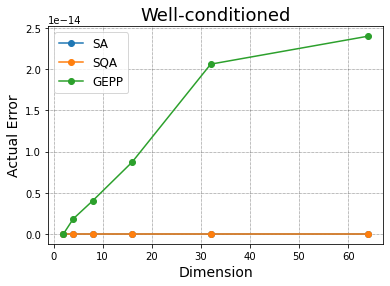

In [21]:
dim_range = [2,4,8,16,32,64]
accuracy = 4
a = -8
b = 8
seed = 42

plot_error_vs_dim(dim_range, accuracy, a, b, seed, num_anneals = 10000, num_reads=10000)


Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 2: SA Error = 0.0, SQA Error = 0.0, GEPP Error = 0.0
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 4: SA Error = 2.449489742783178, SQA Error = 2.0, GEPP Error = 6.0
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)


C:\Users\Max Thomson\AppData\Local\Temp\ipykernel_17940\360343342.py:23: RuntimeWarning: invalid value encountered in long_scalars
  m = AB[j,i] / AB[i,i]
C:\Users\Max Thomson\AppData\Local\Temp\ipykernel_17940\360343342.py:31: RuntimeWarning: invalid value encountered in double_scalars
  x[i] = (AB[i,-1] - np.dot(AB[i,:-1], x)) / AB[i,i]


Dimension 8: SA Error = 11.661903789690601, SQA Error = 9.591663046625438, GEPP Error = nan
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 16: SA Error = 12.884098726725126, SQA Error = 14.212670403551895, GEPP Error = nan
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 32: SA Error = 20.54263858417414, SQA Error = 17.320508075688775, GEPP Error = nan
Precision: 1.0 Range: [-8,8)
Precision: 1.0 Range: [-8,8)
Dimension 64: SA Error = 94.13288479590966, SQA Error = 94.13288479590966, GEPP Error = nan


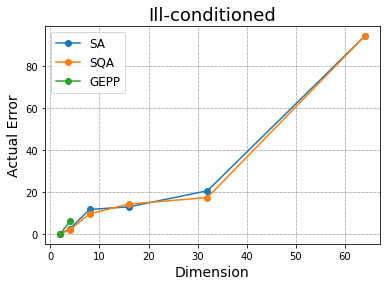

In [23]:
dim_range = [2,4,8,16,32,64]
accuracy = 4
a = -8
b = 8
seed = 42

plot_error_vs_dim_ill(dim_range, accuracy, a, b, seed, num_anneals = 10000, num_reads=10000)
